In [3]:
import os
import sys
module_path = os.path.abspath(os.path.join('../../..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [36]:
# author: Ji Liu email: ji.liu@anl.gov

import itertools, numpy, qiskit
import circuit_cutter
import mlrecon_methods as ml
import json

import numpy as np
import qiskit
from qiskit import *
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, Aer, execute, transpile

from qiskit.transpiler import PassManager

from qiskit.converters import circuit_to_dag
from qiskit.visualization import dag_drawer, plot_histogram
from qiskit.compiler import assemble

from qiskit.tools.monitor import job_monitor, backend_monitor, backend_overview

import qiskit.providers.aer.noise as noise
from qiskit.providers.aer.noise import NoiseModel

from utils.utils import filter_results, dict_to_list, H_distance, total_counts
from vqe_utils import read_from_file, MeasureCircuit, find_commute_groups, evaluation
from mlrecon_methods import run_circuits, collect_fragment_circuits

In [8]:
with open('LiH_cairo_check0.json') as f:
    miti_q0_list = json.load(f)
with open('LiH_cairo_check1.json') as f:
    miti_q1_list = json.load(f)

Untimigated distribution

In [9]:
qubits = 4
# list of all possible measurement outcomes (bitstrings)
all_bits = [ "".join(bits) for bits in itertools.product(["0","1"], repeat = qubits) ]

In [13]:
miti_dist_list = [miti_q0_list[-1], miti_q1_list[-1]]

In [14]:
def load_probs(miti_dist_list, bit_str):
    output_list = []
    for dist in miti_dist_list:
        try:
            miti_count = dist[bit_str]
        except:
            miti_count = 0
        output_list.append(miti_count)
    return output_list

In [15]:
load_probs(miti_dist_list, '0011')

[0.9120075695026171, 0.9311128718670603]

In [16]:
#q0 bitflip
load_probs(miti_dist_list, '0010')

[0, 0.018105986872808334]

In [17]:
#q1 bitflip
load_probs(miti_dist_list, '0001')

[0.031574636048135665, 0]

In [18]:
#q2 bitflip
load_probs(miti_dist_list, '0111')

[0.03766012560393101, 0.035229420582092795]

In [19]:
#q3 bitflip
load_probs(miti_dist_list, '1011')

[0.016003427808832706, 0.014657116595664937]

In [20]:
def bit_weight(dist, index):
    #bitwise distribution
    weight_0 = 0
    weight_1 = 0
    for key in dist.keys():
        if key[len(key) - 1 - index] == '0':
            weight_0 += dist[key]
        elif key[len(key) - 1 - index] == '1':
            weight_1 += dist[key]
        else:
            print("Incorrect key value")
    return weight_0, weight_1

In [22]:
def update_dist(unmiti_dist, miti_dist, index):
    Ppost = {}
    w0, w1 = bit_weight(miti_dist, index)
    u_w0, u_w1 = bit_weight(unmiti_dist, index)
    if w0 == 0:
        w0 = 0.0000000000001
        w1 = 0.9999999999999
    if w1 == 0:
        w1 = 0.0000000000001
        w0 = 0.9999999999999
    if u_w0 == 0:
        u_w0 = 0.0000000000001
        u_w1 = 0.9999999999999
    if u_w1 == 0:
        u_w1 = 0.0000000000001
        u_w0 = 0.9999999999999
        
    for key in unmiti_dist.keys():
        if key[len(key) - 1 - index] == '0':
            Ppost[key] = unmiti_dist[key] / u_w0 * (w0)# / w1)
            #print(w0, w1, w0/w1, Ppost[key])
        elif key[len(key) - 1 - index] == '1':
            Ppost[key] = unmiti_dist[key] / u_w1 * (w1)# / w0)
            #print(w0, w1, w1/w0, Ppost[key])
        else:
            print("Incorrect key value")
    return Ppost

In [23]:
def combine_dist(orign_dist, dist_list):
    output_dist = {}
    for key in orign_dist:
        value = orign_dist[key]
        for dist in dist_list:
            value += dist[key]
        output_dist[key] = value
    return output_dist  

In [24]:
def bayesian_reconstruct(unmiti_dist, miti_dist_list, threshold = 0.0001):
    temp_dist = unmiti_dist.copy()
    h_dist = 1
    while h_dist > threshold:
        temp_dist_start = temp_dist.copy()
        ppost = [0] * len(miti_dist_list)
        for i in range(0, len(miti_dist_list)):
            ppost[i] = update_dist(temp_dist, miti_dist_list[i][0], miti_dist_list[i][1])
        temp_dist = combine_dist(temp_dist, ppost)
        temp_dist = norm_dict(temp_dist)
        h_dist = H_distance_dict(temp_dist, temp_dist_start)
        print("H-dist:", h_dist)
    return temp_dist

In [25]:
def norm_dict(dictionary):
    total = total_counts(dictionary)
    norm_dist = {}
    for i in dictionary.keys():
        norm_dist[i] = dictionary[i]/total
    return norm_dist

In [26]:
miti_dist_index = [[miti_q0_list[-1],0], [miti_q1_list[-1],1]]

In [28]:
post_dist = bayesian_reconstruct(miti_q0_list[-1], miti_dist_index)

H-dist: 0.023983434861067302
H-dist: 0.019491012876128054
H-dist: 0.01586518902907977
H-dist: 0.012927323827979688
H-dist: 0.010540739228943845
H-dist: 0.00859867893722788
H-dist: 0.00701655666576482
H-dist: 0.005726692650461879
H-dist: 0.004674573260971101
H-dist: 0.003816092203231145
H-dist: 0.0031154557788564824
H-dist: 0.002543557400568483
H-dist: 0.002076696210712799
H-dist: 0.0016955556448603056
H-dist: 0.0013843828871140454
H-dist: 0.0011303262043179305
H-dist: 0.0009228978522774912
H-dist: 0.0007535376995162797
H-dist: 0.0006152581019308163
H-dist: 0.0005023545830996997
H-dist: 0.00041016995342900057
H-dist: 0.0003349019034558586
H-dist: 0.00027344600741956203
H-dist: 0.0002232675922643318
H-dist: 0.00018229714962592595
H-dist: 0.00014884495668164067
H-dist: 0.0001215313734044831
H-dist: 9.922993542881853e-05


In [29]:
#the success probability after bayesian reconstruction
post_dist['0011']

0.9433519576273629

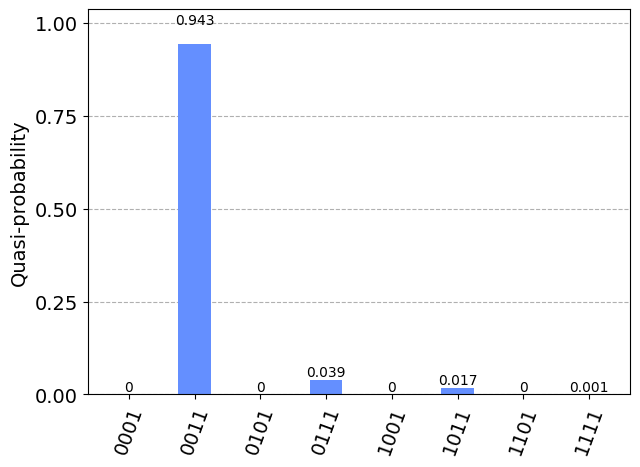

In [32]:
plot_histogram(post_dist)

In [40]:
full_dist = []
for idx in range(0, len(miti_q0_list)):
    miti_dist_index = [[miti_q0_list[idx],0], [miti_q1_list[idx],1]]
    post_dist = bayesian_reconstruct(miti_q1_list[idx], miti_dist_index)
    full_dist.append(post_dist)

H-dist: 0.010152535856746627
H-dist: 0.006758805220742821
H-dist: 0.0045030858843553906
H-dist: 0.0030012531373456008
H-dist: 0.002000608811444595
H-dist: 0.0013336793873325252
H-dist: 0.0008891068231001506
H-dist: 0.0005927376000586596
H-dist: 0.00039516084629508
H-dist: 0.0002634431343038928
H-dist: 0.00017563086629761773
H-dist: 0.00011708885296900325
H-dist: 7.806042650370534e-05
H-dist: 0.009590246285979293
H-dist: 0.006384944660888625
H-dist: 0.00425405938088515
H-dist: 0.00283526160210581
H-dist: 0.0018899380045564898
H-dist: 0.0012598873400225957
H-dist: 0.0008399042464827258
H-dist: 0.0005599310737721323
H-dist: 0.0003732869384239687
H-dist: 0.0002488587503731625
H-dist: 0.00016590680818199117
H-dist: 0.0001106053963187211
H-dist: 7.373761089794709e-05
H-dist: 0.01775490625611442
H-dist: 0.014459636752289017
H-dist: 0.011786134930257547
H-dist: 0.009612440032482
H-dist: 0.007842608843125772
H-dist: 0.006400249416996121
H-dist: 0.005224034569879855
H-dist: 0.004264456117162087


In [41]:
full_dist

[{'0010': 0.0601622725112951,
  '0000': 0.05972881159046387,
  '0110': 0.06600784751758604,
  '0100': 0.0658450896001835,
  '0011': 0.060618291956454406,
  '0001': 0.06062972947708183,
  '0111': 0.06505309595747083,
  '0101': 0.065283931567231,
  '1010': 0.057501892904951606,
  '1000': 0.05702210432851316,
  '1110': 0.06720443416323534,
  '1100': 0.06699756080473278,
  '1011': 0.05676592369009951,
  '1001': 0.05676964678677306,
  '1111': 0.06711116515611189,
  '1101': 0.06729820198781611},
 {'0000': 0.2382042621271082,
  '0010': 0.23850599210780535,
  '0100': 0.008106748085827026,
  '0110': 0.008064931100091762,
  '0001': 0.2406083922247857,
  '0011': 0.23953846143425786,
  '0101': 0.0077083038013940905,
  '0111': 0.0076535518966607576,
  '1000': 0.002911329275504261,
  '1010': 0.0029131991216746777,
  '1001': 0.0028974122649914726,
  '1011': 0.0028874165598989847},
 {'0010': 7.441382900835103e-08,
  '0110': 8.97014358753793e-08,
  '0011': 0.24148690433294193,
  '0111': 0.2635199554617

In [42]:
pauli_list = read_from_file('LiH_hamiltonian.txt')
pauli_commute = find_commute_groups(pauli_list)

In [43]:
final_expect_val = 0
for i in range(0, len(pauli_commute)):
    group = pauli_commute[i]
    for Pauli_tuple in group:
        coeff = Pauli_tuple[1]
        final_expect_val += coeff * evaluation(full_dist[i], shots = 1, Pauli = Pauli_tuple[0])  

In [44]:
final_expect_val

(-1.057980709452889+0j)